In [1]:
import numpy as np
import pandas as pd

import os,sys,random,math,time
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [2]:
'''
district_id 学区唯一标识
state 学区所属州
locale 所处区域类型：城市、郊区、城镇和农村
pct_black/hispanic 黑人或者西班牙裔学生占比
pct_free/reduced 有资格获得免费或者减价午餐的学生占比
county_connections_ration 高速网络在一个方向或住户或者比例
pp_total_raw 给定学区的每名学生的国家总支出
'''
districts_df = pd.read_csv("D:/下载/学习文档/COVID-19与在线数字教育/districts_info.csv")
# districts_df = districts_df.fillna('')
districts_df = districts_df.dropna()
districts_df['pct_black'] = districts_df['pct_black/hispanic'].apply(lambda pbh:float(pbh[1:-1].split(',')[0].strip()) if pbh!='' else '')
districts_df['pct_hispanic'] = districts_df['pct_black/hispanic'].apply(lambda pbh:float(pbh[1:-1].split(',')[1].strip()) if pbh!='' else '')
districts_df['pct_free'] = districts_df['pct_free/reduced'].apply(lambda pbh:float(pbh[1:-1].split(',')[0].strip()) if pbh!='' else '')
districts_df['pct_reduced'] = districts_df['pct_free/reduced'].apply(lambda pbh:float(pbh[1:-1].split(',')[1].strip()) if pbh!='' else '')
districts_df['ratio_direction'] = districts_df['county_connections_ratio'].apply(lambda pbh:float(pbh[1:-1].split(',')[0].strip()) if pbh!='' else '')
districts_df['ratio_households'] = districts_df['county_connections_ratio'].apply(lambda pbh:float(pbh[1:-1].split(',')[1].strip()) if pbh!='' else '')
districts_df['pp_total_a'] = districts_df['pp_total_raw'].apply(lambda pbh:float(pbh[1:-1].split(',')[0].strip()) if pbh!='' else '')
districts_df['pp_total_b'] = districts_df['pp_total_raw'].apply(lambda pbh:float(pbh[1:-1].split(',')[1].strip()) if pbh!='' else '')
districts_df = districts_df[['district_id','state','locale','pct_black','pct_hispanic',
                             'pct_free','pct_reduced','ratio_direction','ratio_households','pp_total_a','pp_total_b']]
districts_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88 entries, 0 to 230
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   district_id       88 non-null     int64  
 1   state             88 non-null     object 
 2   locale            88 non-null     object 
 3   pct_black         88 non-null     float64
 4   pct_hispanic      88 non-null     float64
 5   pct_free          88 non-null     float64
 6   pct_reduced       88 non-null     float64
 7   ratio_direction   88 non-null     float64
 8   ratio_households  88 non-null     float64
 9   pp_total_a        88 non-null     float64
 10  pp_total_b        88 non-null     float64
dtypes: float64(8), int64(1), object(2)
memory usage: 8.2+ KB


In [3]:
districts_df.head()

,district_id,state,locale,pct_black,pct_hispanic,pct_free,pct_reduced,ratio_direction,ratio_households,pp_total_a,pp_total_b
0,8815,Illinois,Suburb,0.0,0.2,0.0,0.2,0.18,1.0,14000.0,16000.0
2,4921,Utah,Suburb,0.0,0.2,0.2,0.4,0.18,1.0,6000.0,8000.0
5,5987,Wisconsin,Suburb,0.0,0.2,0.0,0.2,0.18,1.0,10000.0,12000.0
6,3710,Utah,Suburb,0.0,0.2,0.4,0.6,0.18,1.0,6000.0,8000.0
7,7177,North Carolina,Suburb,0.2,0.4,0.2,0.4,0.18,1.0,8000.0,10000.0


In [4]:
'''
LP ID 产品唯一标识
URL 产品网站链接
Product Name 产品名
Provider/Company Name 产品提供商名 
Sector(s) 使用该产品的教育部门
Primary Essential Function 产品的基本功能。这里有两层标签。产品首先被标记为以下三个类别之一：LC = 学习和课程，CM = 课堂管理，
                            以及 SDO = 学校和学区运营。这些类别中的每一个都有多个子类别
'''
products_df = pd.read_csv("D:/下载/学习文档/COVID-19与在线数字教育/products_info.csv")
products_df = products_df.dropna()
products_df['PEF L1'] = products_df['Primary Essential Function'].apply(lambda pef:pef.split('-')[0].strip())
products_df['PEF L2'] = products_df['Primary Essential Function'].apply(lambda pef:pef.split('-')[1].strip())
products_df = products_df[['LP ID','URL','Product Name','Provider/Company Name','Sector(s)','PEF L1','PEF L2']]
products_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 352 entries, 0 to 369
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   LP ID                  352 non-null    int64 
 1   URL                    352 non-null    object
 2   Product Name           352 non-null    object
 3   Provider/Company Name  352 non-null    object
 4   Sector(s)              352 non-null    object
 5   PEF L1                 352 non-null    object
 6   PEF L2                 352 non-null    object
dtypes: int64(1), object(6)
memory usage: 22.0+ KB


In [5]:
products_df.head()

,LP ID,URL,Product Name,Provider/Company Name,Sector(s),PEF L1,PEF L2
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC,Digital Learning Platforms
1,66933,https://abcmouse.com,ABCmouse.com,"Age of Learning, Inc",PreK-12,LC,Digital Learning Platforms
2,50479,https://www.abcya.com,ABCya!,"ABCya.com, LLC",PreK-12,LC,"Sites, Resources & Reference"
3,92993,http://www.aleks.com/,ALEKS,McGraw-Hill PreK-12,PreK-12; Higher Ed,LC,Digital Learning Platforms
4,73104,https://www.achieve3000.com/,Achieve3000,Achieve3000,PreK-12,LC,Digital Learning Platforms


In [6]:
'''
学区级别的汇总数据，文件名即表示学区唯一标识
time 日期
Lp_id 产品唯一标识
pct_access 该学区学生当天在该产品上至少有一个页面访问的比例
engagement_index 当前学区在当前产品在当前每千名学生访问页面总数
'''

# 定义读取 engagement 数据的函数
def read_engagement(district_id):
    # 使用 os.path.join 处理文件路径，确保路径的拼接正确
    file_path = os.path.join("D:/下载/学习文档/COVID-19与在线数字教育", str(district_id) + ".csv")
    
    # 读取 CSV 文件
    engagement = pd.read_csv(file_path)
    
    # 将缺失值填充为 0
    engagement = engagement.fillna(0)
    
    # 添加学区唯一标识
    engagement['dt_id'] = district_id
    
    return engagement

# 读取 8815 学区的数据
engagement_8815 = read_engagement(8815)

# 输出数据的信息
engagement_8815.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134926 entries, 0 to 134925
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   time              134926 non-null  object 
 1   lp_id             134926 non-null  int64  
 2   pct_access        134926 non-null  float64
 3   engagement_index  134926 non-null  float64
 4   dt_id             134926 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 5.1+ MB


In [7]:
engagement_8815.head()

,time,lp_id,pct_access,engagement_index,dt_id
0,2020-01-27,32213,100.00,3000.00,8815
1,2020-02-25,90153,33.33,2666.67,8815
2,2020-02-25,99916,0.00,0.00,8815
3,2020-02-25,28504,0.00,0.00,8815
4,2020-02-25,95731,33.33,333.33,8815


In [8]:
'''
date 日期
state 州
cases 累计确诊
deaths 累计死亡
'''

# 正确的读取文件路径，去掉路径中的多余引号
us_covid = pd.read_csv('D:/下载/学习文档/COVID-19与在线数字教育/us-counties.csv')

# 删除 'county' 列
us_covid = us_covid.drop('county', axis=1)

# 按日期和州汇总病例数和死亡数
us_covid = us_covid.groupby(by=['date', 'state']).agg({'cases': 'sum', 'deaths': 'sum'}).reset_index()

# 输出数据的信息
us_covid.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28834 entries, 0 to 28833
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    28834 non-null  object 
 1   state   28834 non-null  object 
 2   cases   28834 non-null  int64  
 3   deaths  28834 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 901.2+ KB


In [9]:
us_covid.head()

,date,state,cases,deaths
0,2020-01-21,Washington,1,0.0
1,2020-01-22,Washington,1,0.0
2,2020-01-23,Washington,1,0.0
3,2020-01-24,Illinois,1,0.0
4,2020-01-24,Washington,1,0.0


In [10]:
def district_product_covid(district_id):
    engagement_8815 = read_engagement(district_id)
    districts_8815 = districts_df[districts_df['district_id']==district_id]
    covid_8815 = us_covid[us_covid['state']==districts_8815['state'].iloc[0]]
    dpc_df = engagement_8815.merge(districts_8815,left_on='dt_id',right_on='district_id',how='inner').merge(covid_8815,left_on='time',right_on='date',how='inner')
    return dpc_df

dpc_df = district_product_covid(8815).sort_values(by='date')
dpc_df = dpc_df[['date','state_x','district_id','lp_id','locale','pct_access','engagement_index',
                 'pct_black','pct_hispanic','pct_free','pct_reduced','ratio_direction','ratio_households',
                'pp_total_a','pp_total_b','cases','deaths']]
dpc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134926 entries, 0 to 134925
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   date              134926 non-null  object 
 1   state_x           134926 non-null  object 
 2   district_id       134926 non-null  int64  
 3   lp_id             134926 non-null  int64  
 4   locale            134926 non-null  object 
 5   pct_access        134926 non-null  float64
 6   engagement_index  134926 non-null  float64
 7   pct_black         134926 non-null  float64
 8   pct_hispanic      134926 non-null  float64
 9   pct_free          134926 non-null  float64
 10  pct_reduced       134926 non-null  float64
 11  ratio_direction   134926 non-null  float64
 12  ratio_households  134926 non-null  float64
 13  pp_total_a        134926 non-null  float64
 14  pp_total_b        134926 non-null  float64
 15  cases             134926 non-null  int64  
 16  deaths            134926 

In [11]:
dpc_df.head()

,date,state_x,district_id,lp_id,locale,pct_access,engagement_index,pct_black,pct_hispanic,pct_free,pct_reduced,ratio_direction,ratio_households,pp_total_a,pp_total_b,cases,deaths
0,2020-01-27,Illinois,8815,32213,Suburb,100.00,3000.00,0.0,0.2,0.0,0.2,0.18,1.0,14000.0,16000.0,1,0.0
1,2020-02-25,Illinois,8815,90153,Suburb,33.33,2666.67,0.0,0.2,0.0,0.2,0.18,1.0,14000.0,16000.0,2,0.0
2,2020-02-25,Illinois,8815,99916,Suburb,0.00,0.00,0.0,0.2,0.0,0.2,0.18,1.0,14000.0,16000.0,2,0.0
3,2020-02-25,Illinois,8815,28504,Suburb,0.00,0.00,0.0,0.2,0.0,0.2,0.18,1.0,14000.0,16000.0,2,0.0
4,2020-02-25,Illinois,8815,95731,Suburb,33.33,333.33,0.0,0.2,0.0,0.2,0.18,1.0,14000.0,16000.0,2,0.0


In [12]:
def bar_plot(data,title,y='district_id',xlabel='US State',ylabel='Number of school districts',rotation=90):
    plt.figure(figsize=(20,5))
    plt.bar(x=[str(x) for x in data.index.tolist()],height=data[y].tolist())
    plt.xticks(rotation=rotation)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [13]:
def line_plot(data,product_id=32213,y='pct_access'):
    plt.figure(figsize=(20,8))
    tmp = data[data['lp_id']==product_id]

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    date = [datetime.strptime(d, '%Y-%m-%d').date() for d in tmp['date'].tolist()]
    plt.xticks(date[::30])

    plt.subplot(211)

    plt.plot(date,tmp[y].tolist(),label=y)
    plt.legend()
    plt.twinx()
    plt.plot(date,tmp['cases'].tolist(),color='red',label='cases')
    plt.legend()

    plt.subplot(212)

    plt.plot(date,tmp[y].tolist(),label=y)
    plt.legend()
    plt.twinx()
    plt.plot(date,tmp['deaths'].tolist(),color='gray',label='deaths')
    plt.legend()

    plt.show()

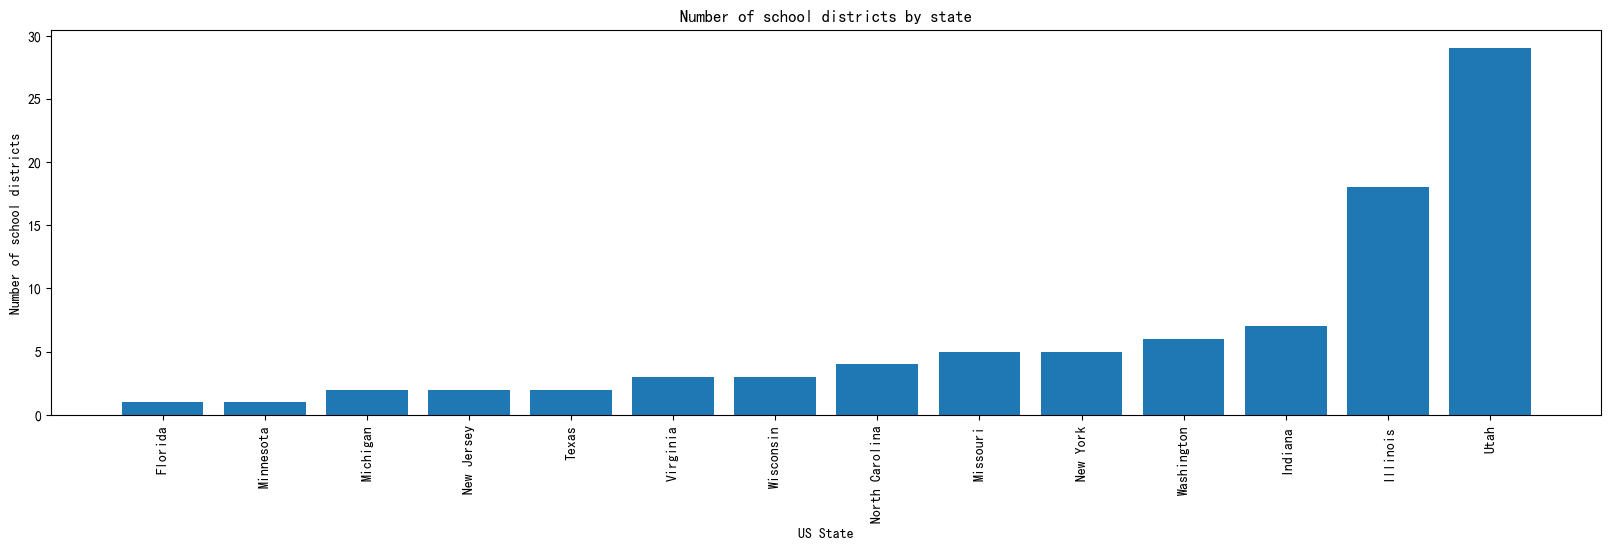

In [14]:
state_group = districts_df.groupby('state')[['district_id']].count().sort_values(by='district_id')
bar_plot(state_group,'Number of school districts by state')


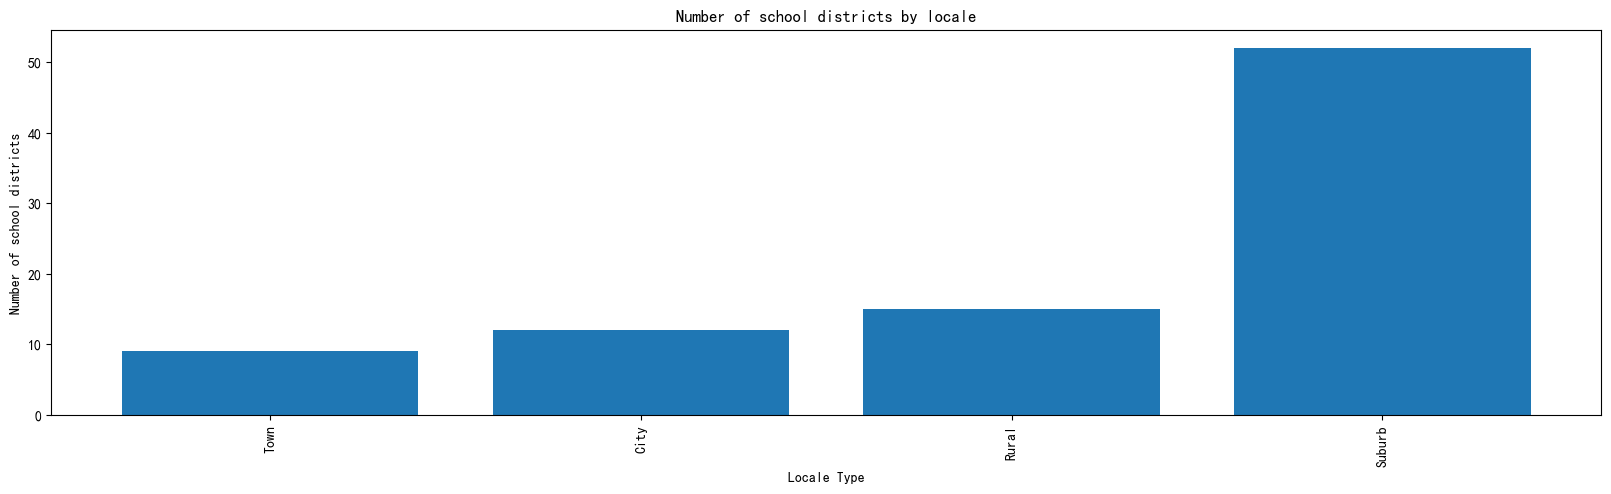

In [15]:
state_group = districts_df.groupby('locale')[['district_id']].count().sort_values(by='district_id')
bar_plot(state_group,'Number of school districts by locale',xlabel='Locale Type')

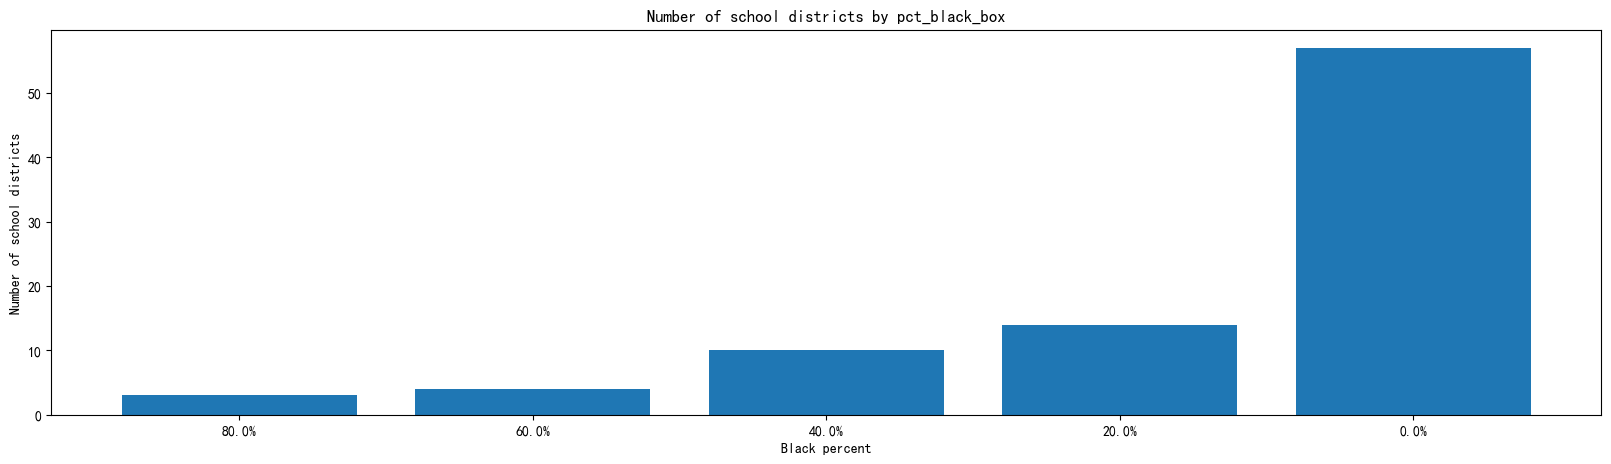

In [16]:
districts_df['pct_black_box'] = districts_df['pct_black'].apply(lambda pb:str(float(pb)*100)+'%')
state_group = districts_df.groupby('pct_black_box')[['district_id']].count().sort_values(by='district_id')
bar_plot(state_group,'Number of school districts by pct_black_box',xlabel='Black percent',rotation=0)

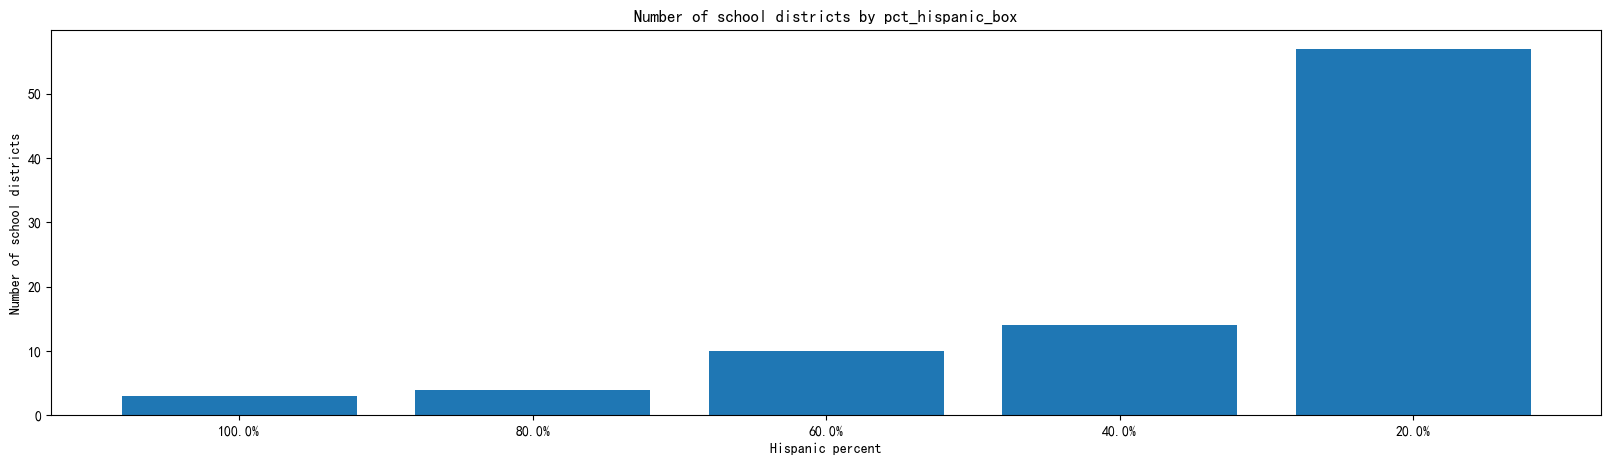

In [17]:
districts_df['pct_hispanic_box'] = districts_df['pct_hispanic'].apply(lambda pb:str(float(pb)*100)+'%')
state_group = districts_df.groupby('pct_hispanic_box')[['district_id']].count().sort_values(by='district_id')
bar_plot(state_group,'Number of school districts by pct_hispanic_box',xlabel='Hispanic percent',rotation=0)

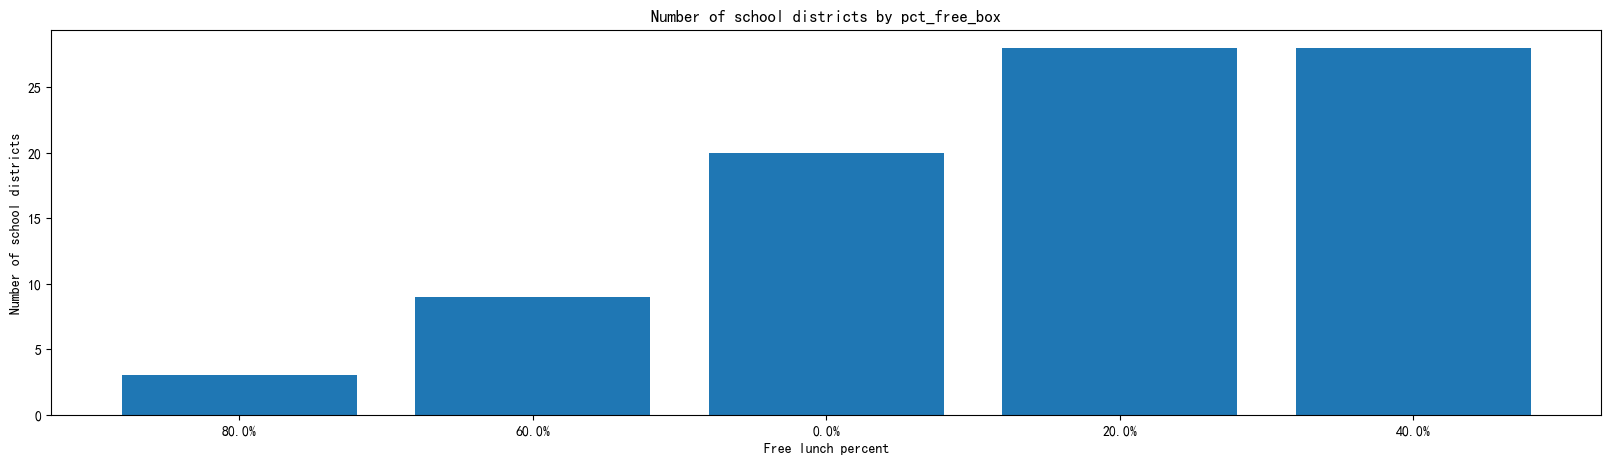

In [18]:
districts_df['pct_free_box'] = districts_df['pct_free'].apply(lambda pb:str(float(pb)*100)+'%')
state_group = districts_df.groupby('pct_free_box')[['district_id']].count().sort_values(by='district_id')
bar_plot(state_group,'Number of school districts by pct_free_box',xlabel='Free lunch percent',rotation=0)

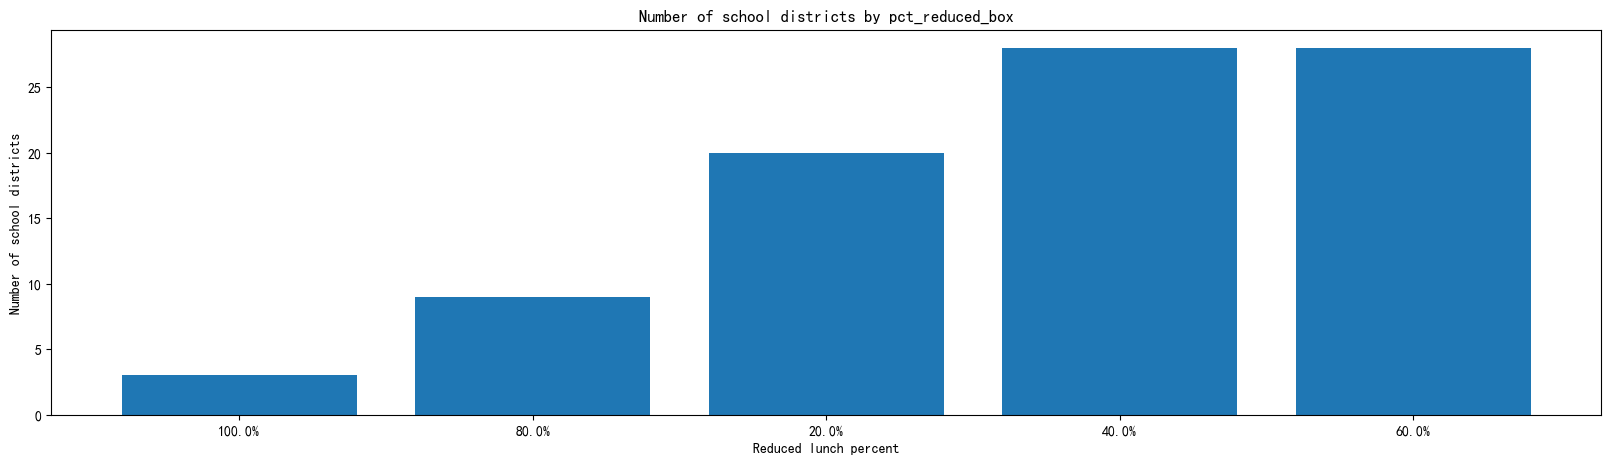

In [19]:
districts_df['pct_reduced_box'] = districts_df['pct_reduced'].apply(lambda pb:str(float(pb)*100)+'%')
state_group = districts_df.groupby('pct_reduced_box')[['district_id']].count().sort_values(by='district_id')
bar_plot(state_group,'Number of school districts by pct_reduced_box',xlabel='Reduced lunch percent',rotation=0)

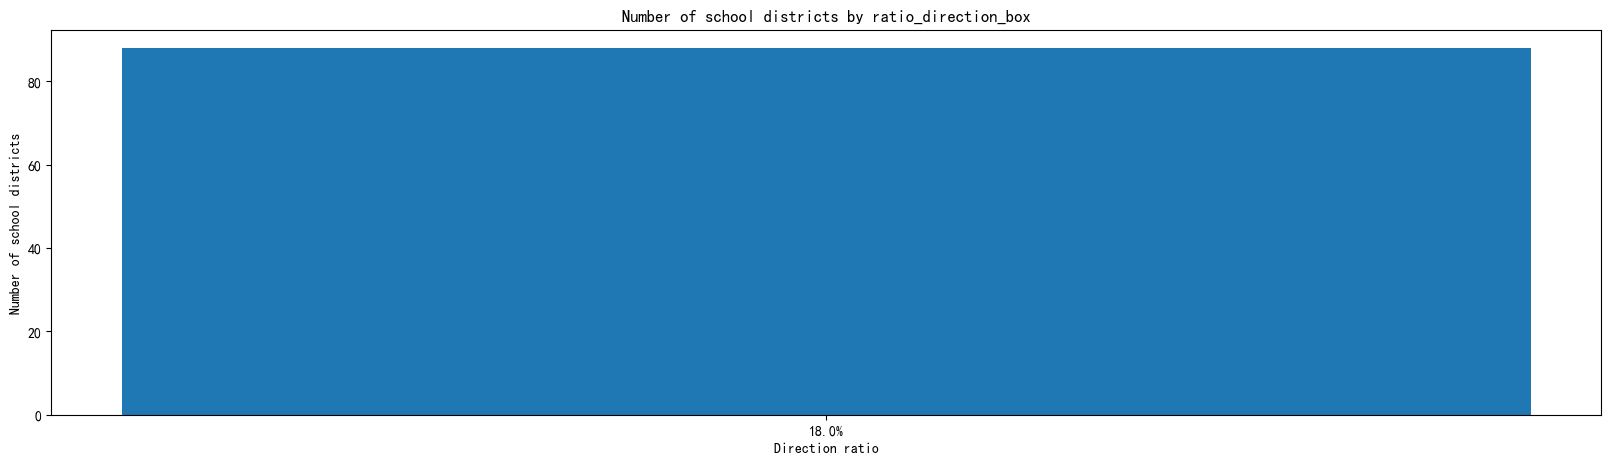

In [20]:
districts_df['ratio_direction_box'] = districts_df['ratio_direction'].apply(lambda pb:str(float(pb)*100)+'%')
state_group = districts_df.groupby('ratio_direction_box')[['district_id']].count().sort_values(by='district_id')
bar_plot(state_group,'Number of school districts by ratio_direction_box',xlabel='Direction ratio',rotation=0)

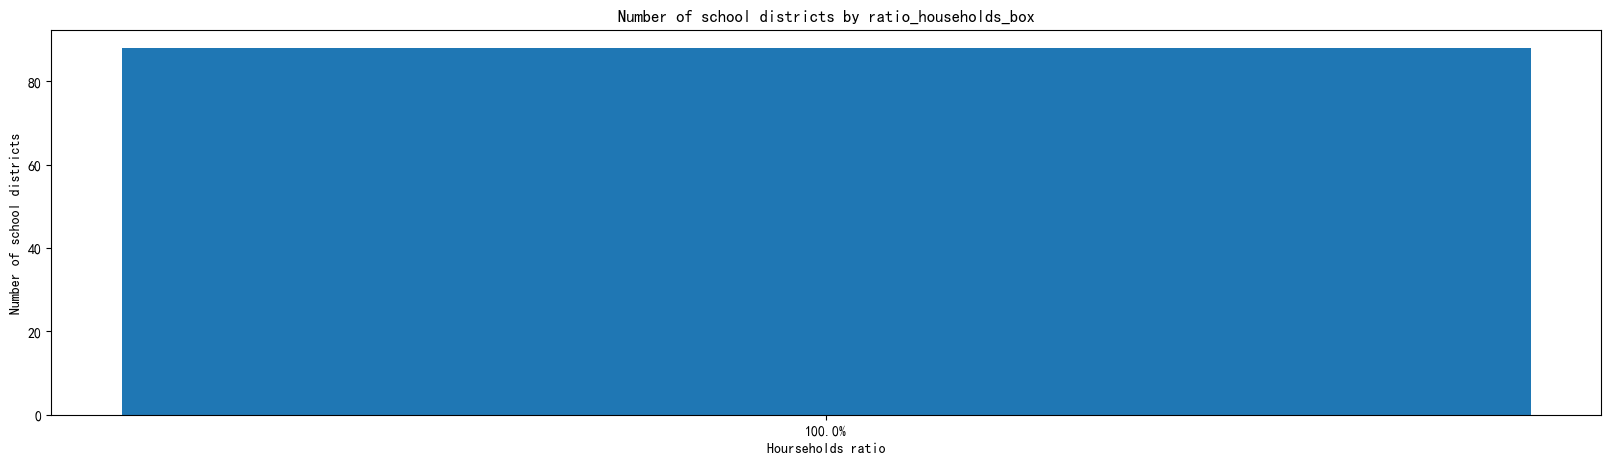

In [21]:
districts_df['ratio_households_box'] = districts_df['ratio_households'].apply(lambda pb:str(float(pb)*100)+'%')
state_group = districts_df.groupby('ratio_households_box')[['district_id']].count().sort_values(by='district_id')
bar_plot(state_group,'Number of school districts by ratio_households_box',xlabel='Hourseholds ratio',rotation=0)

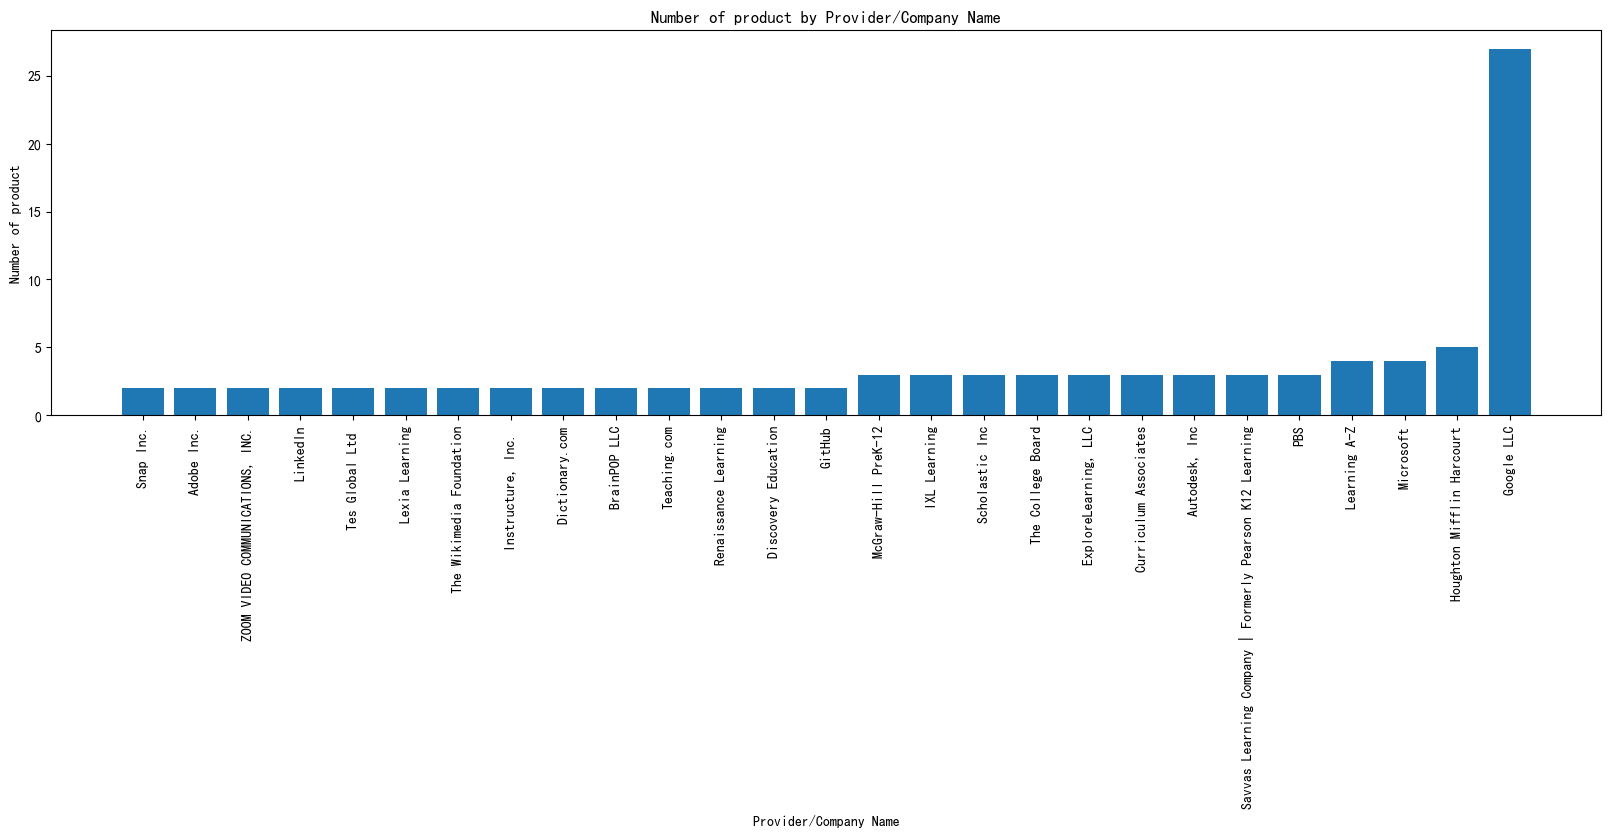

In [22]:
state_group = products_df.groupby('Provider/Company Name')[['LP ID']].count().sort_values(by='LP ID')
state_group = state_group[state_group['LP ID']>1]
bar_plot(state_group,'Number of product by Provider/Company Name',y='LP ID',xlabel='Provider/Company Name',ylabel='Number of product',rotation=90)

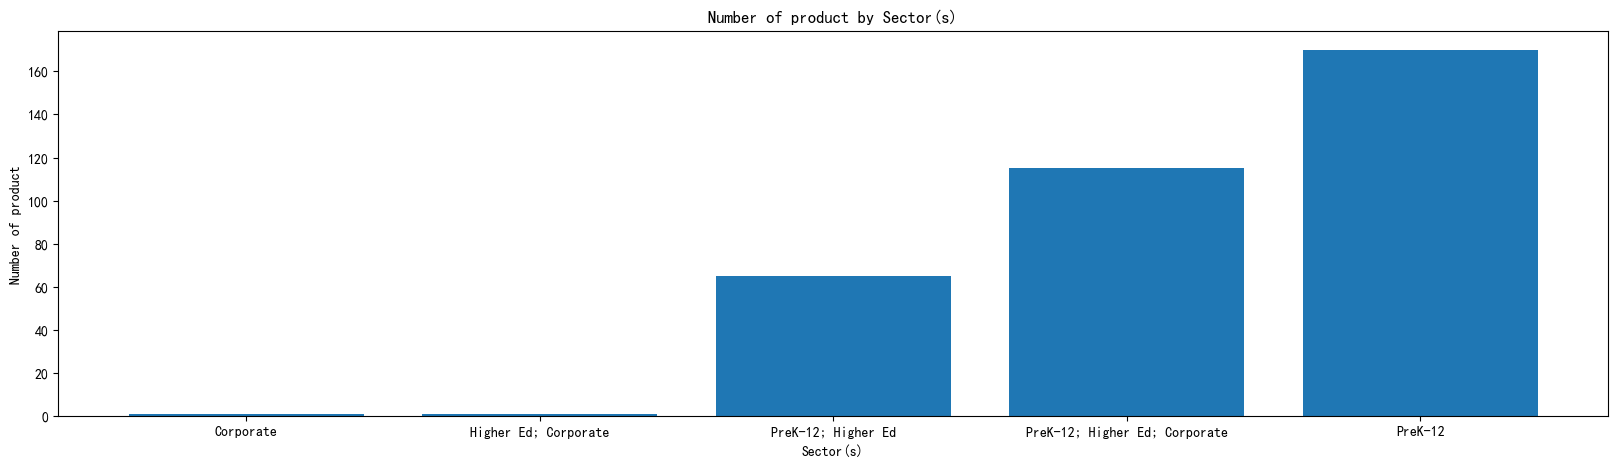

In [23]:
state_group = products_df.groupby('Sector(s)')[['LP ID']].count().sort_values(by='LP ID')
bar_plot(state_group,'Number of product by Sector(s)',y='LP ID',xlabel='Sector(s)',ylabel='Number of product',rotation=0)

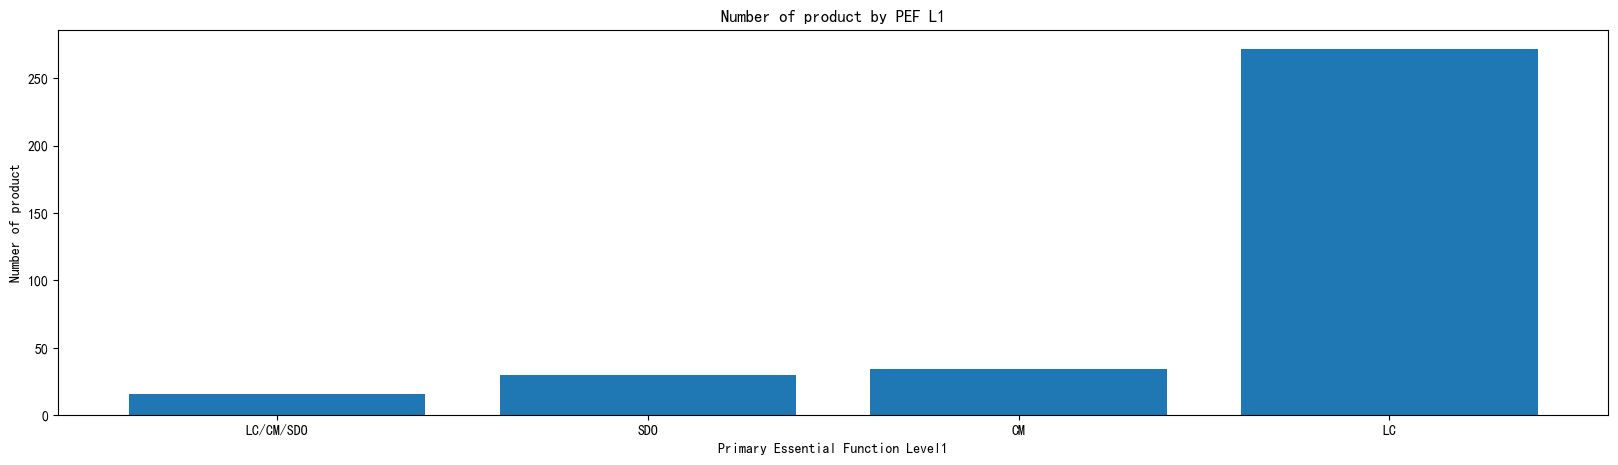

In [24]:
state_group = products_df.groupby('PEF L1')[['LP ID']].count().sort_values(by='LP ID')
bar_plot(state_group,'Number of product by PEF L1',y='LP ID',xlabel='Primary Essential Function Level1',ylabel='Number of product',rotation=0)

In [25]:
engagement_8815 = read_engagement(8815)

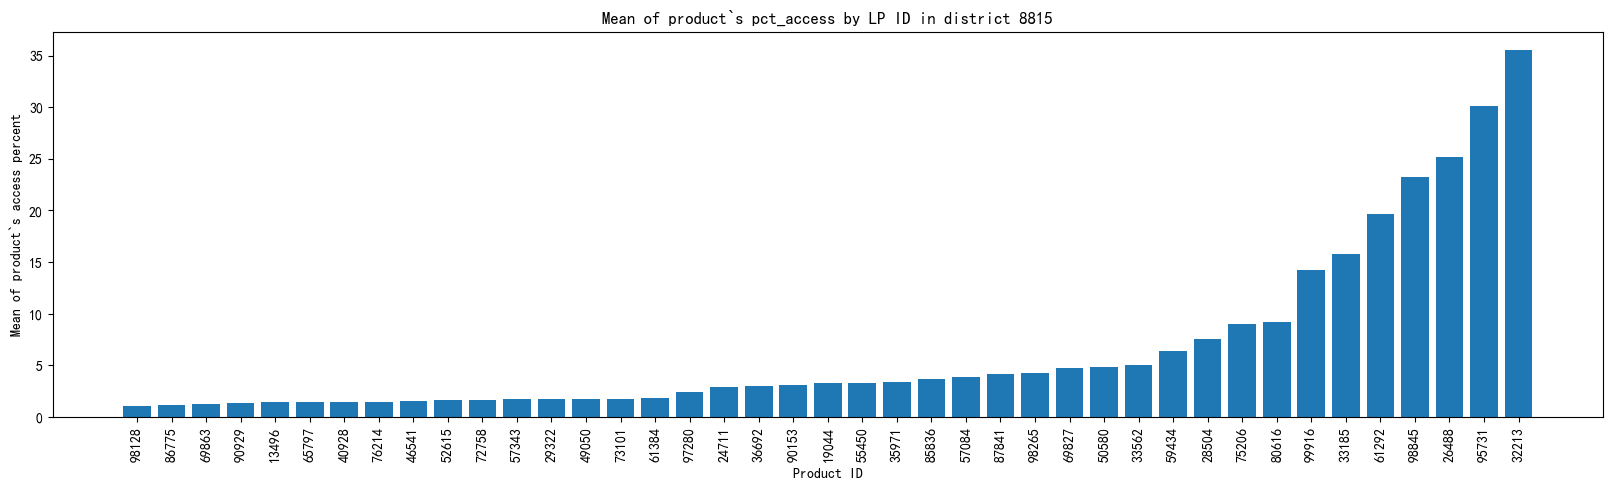

In [26]:
group_8815 = engagement_8815.groupby('lp_id')[['pct_access']].mean().sort_values(by='pct_access')
group_8815 = group_8815[group_8815['pct_access']>1]
bar_plot(group_8815,'Mean of product`s pct_access by LP ID in district 8815',y='pct_access',xlabel='Product ID',ylabel='Mean of product`s access percent',rotation=90)

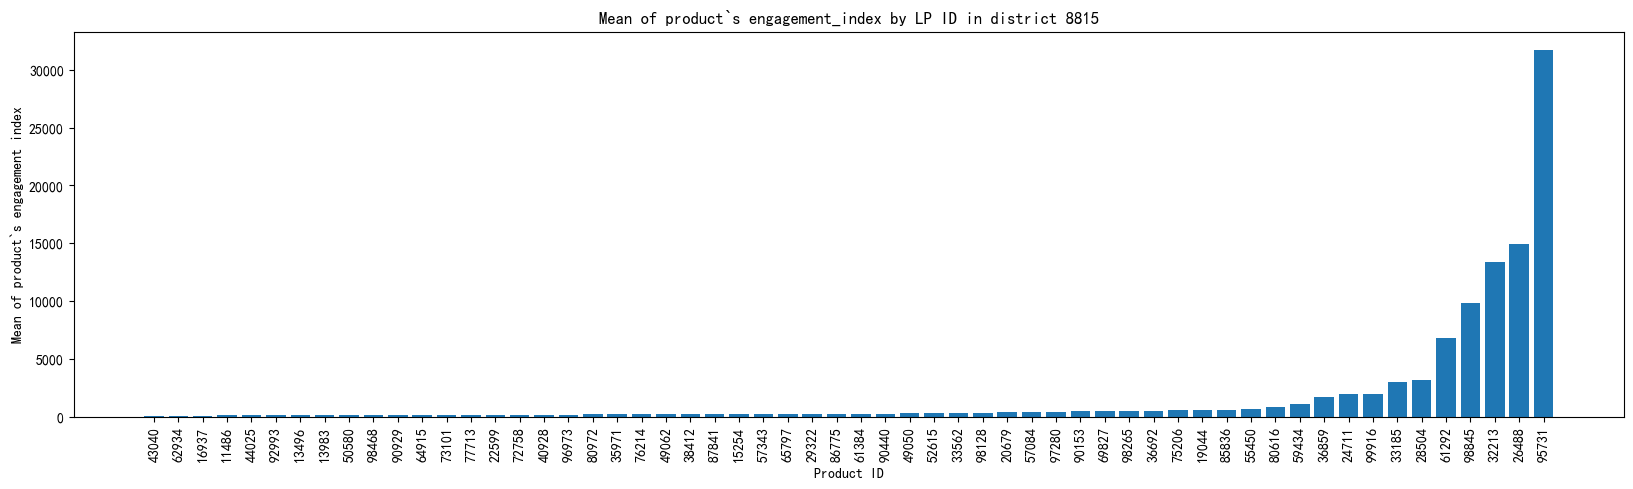

In [27]:
group_8815 = engagement_8815.groupby('lp_id')[['engagement_index']].mean().sort_values(by='engagement_index')
group_8815 = group_8815[group_8815['engagement_index']>100]
bar_plot(group_8815,'Mean of product`s engagement_index by LP ID in district 8815',y='engagement_index',xlabel='Product ID',ylabel='Mean of product`s engagement index',rotation=90)


In [28]:
dpc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134926 entries, 0 to 134925
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   date              134926 non-null  object 
 1   state_x           134926 non-null  object 
 2   district_id       134926 non-null  int64  
 3   lp_id             134926 non-null  int64  
 4   locale            134926 non-null  object 
 5   pct_access        134926 non-null  float64
 6   engagement_index  134926 non-null  float64
 7   pct_black         134926 non-null  float64
 8   pct_hispanic      134926 non-null  float64
 9   pct_free          134926 non-null  float64
 10  pct_reduced       134926 non-null  float64
 11  ratio_direction   134926 non-null  float64
 12  ratio_households  134926 non-null  float64
 13  pp_total_a        134926 non-null  float64
 14  pp_total_b        134926 non-null  float64
 15  cases             134926 non-null  int64  
 16  deaths            134926 

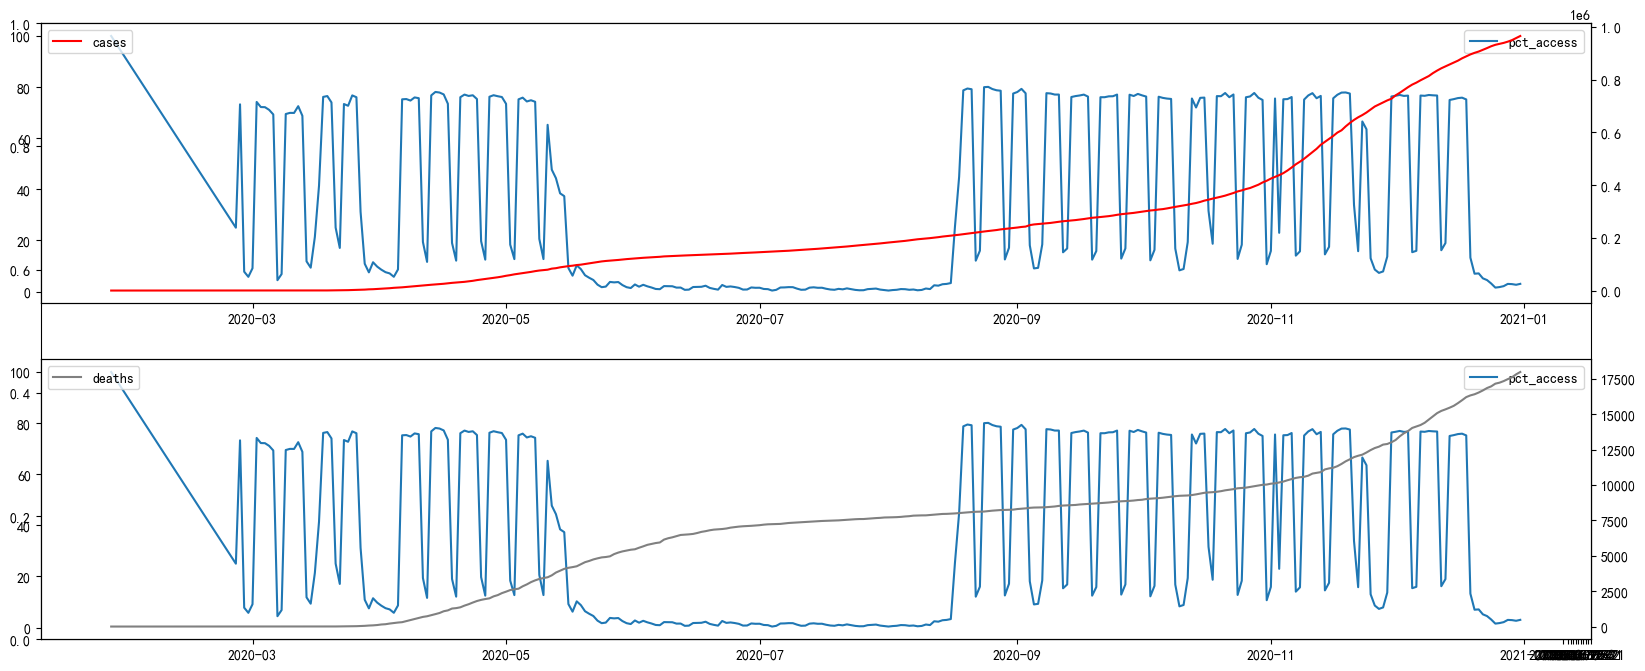

In [29]:
line_plot(dpc_df,y='pct_access')

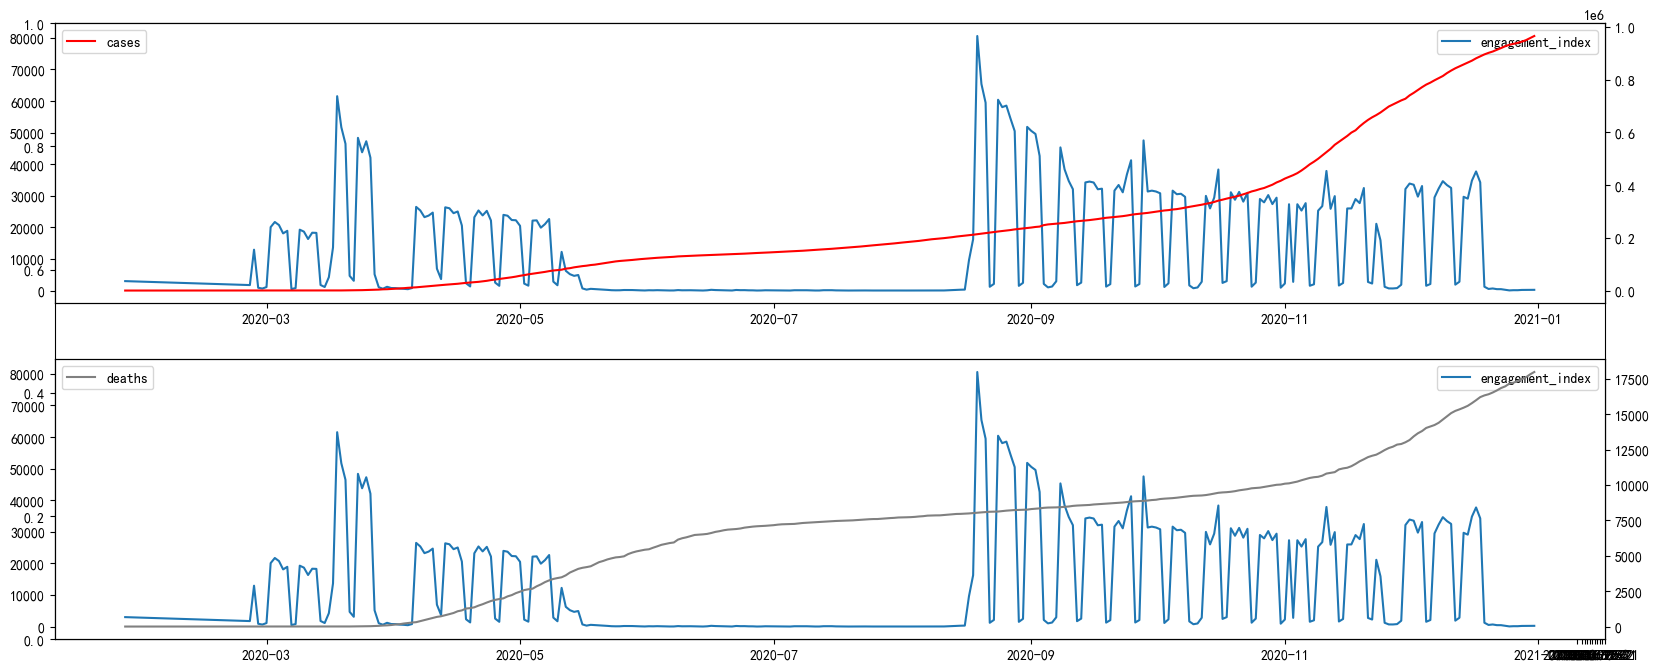

In [30]:
line_plot(dpc_df,y='engagement_index')


In [31]:
import pandas as pd

# 读取数据
districts_df = pd.read_csv("D:/下载/学习文档/COVID-19与在线数字教育/districts_info.csv")

# 对缺失值进行填充或处理，避免直接删除所有行
districts_df = districts_df.fillna('')

# 处理 'pct_black/hispanic' 列，解析其中的黑人人口比例和西班牙裔人口比例
districts_df['pct_black'] = districts_df['pct_black/hispanic'].apply(lambda pbh: float(pbh[1:-1].split(',')[0].strip()) if '(' in pbh and ')' in pbh else None)
districts_df['pct_hispanic'] = districts_df['pct_black/hispanic'].apply(lambda pbh: float(pbh[1:-1].split(',')[1].strip()) if '(' in pbh and ')' in pbh else None)

# 处理 'pct_free/reduced' 列，解析其中的免费和减价午餐学生占比
districts_df['pct_free'] = districts_df['pct_free/reduced'].apply(lambda pbh: float(pbh[1:-1].split(',')[0].strip()) if '(' in pbh and ')' in pbh else None)
districts_df['pct_reduced'] = districts_df['pct_free/reduced'].apply(lambda pbh: float(pbh[1:-1].split(',')[1].strip()) if '(' in pbh and ')' in pbh else None)

# 处理 'county_connections_ratio' 列，解析其中的网络连接比例
districts_df['ratio_direction'] = districts_df['county_connections_ratio'].apply(lambda pbh: float(pbh[1:-1].split(',')[0].strip()) if '(' in pbh and ')' in pbh else None)
districts_df['ratio_households'] = districts_df['county_connections_ratio'].apply(lambda pbh: float(pbh[1:-1].split(',')[1].strip()) if '(' in pbh and ')' in pbh else None)

# 处理 'pp_total_raw' 列，解析每名学生的国家总支出
districts_df['pp_total_a'] = districts_df['pp_total_raw'].apply(lambda pbh: float(pbh[1:-1].split(',')[0].strip()) if '(' in pbh and ')' in pbh else None)
districts_df['pp_total_b'] = districts_df['pp_total_raw'].apply(lambda pbh: float(pbh[1:-1].split(',')[1].strip()) if '(' in pbh and ')' in pbh else None)

# 选择所需的列
districts_df = districts_df[['district_id', 'state', 'locale', 'pct_black', 'pct_hispanic',
                             'pct_free', 'pct_reduced', 'ratio_direction', 'ratio_households', 'pp_total_a', 'pp_total_b']]

# 输出数据框的信息
districts_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   district_id       233 non-null    int64 
 1   state             233 non-null    object
 2   locale            233 non-null    object
 3   pct_black         0 non-null      object
 4   pct_hispanic      0 non-null      object
 5   pct_free          0 non-null      object
 6   pct_reduced       0 non-null      object
 7   ratio_direction   0 non-null      object
 8   ratio_households  0 non-null      object
 9   pp_total_a        0 non-null      object
 10  pp_total_b        0 non-null      object
dtypes: int64(1), object(10)
memory usage: 20.2+ KB
